In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1aJsbt04Jz9xcLP_lg7fvP4Bpdce6GQlC/Pytorch-Models


In [ ]:
!pip uninstall onnxruntime -y
!pip install onnxruntime-gpu

In [62]:
import onnxruntime
import numpy as np
import cv2
import torch

img_path = "datasets/pose-tests/pose (7).jpg"

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (288, 384))
img_input = img_resized.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Run inference
session = onnxruntime.InferenceSession("mmpose/checkpoints/rtmpose_onnx_models/hrnet_coco_w48_384x288.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

print("Output:", [o.shape for o in outputs])

Output: [(1, 17, 96, 72)]


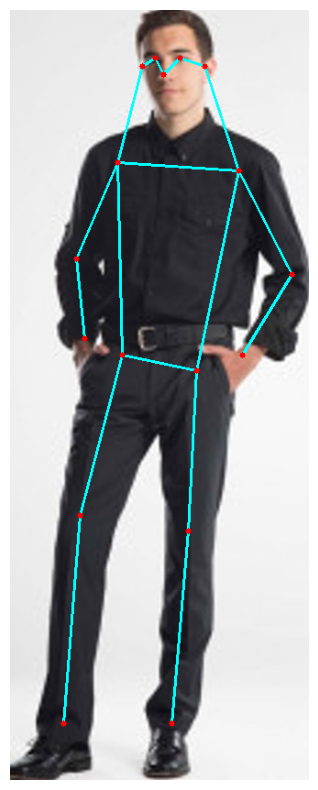

In [63]:
import cv2
import numpy as np
import onnxruntime
from matplotlib import pyplot as plt

# -------- Heatmap decode (HRNet ONNX) --------
def decode_single_person_heatmap(heatmaps, input_w, input_h, thr_kp=0.0):
    """
    heatmaps: (C, Hm, Wm)  -- 2D heatmap for each joint
    input_w, input_h: network input resolution (e.g., 288, 384)
    returns: (C, 3) [x, y, conf] in input image coordinates
    """
    C, Hm, Wm = heatmaps.shape
    kpts = np.zeros((C, 3), dtype=np.float32)

    for j in range(C):
        hm = heatmaps[j]
        # argmax
        y, x = np.unravel_index(hm.argmax(), hm.shape)
        conf = float(hm[y, x])

        # scale back to input image resolution
        x = x * (input_w / float(Wm))
        y = y * (input_h / float(Hm))

        if conf > thr_kp:
            kpts[j] = [x, y, conf]

    return kpts

# -------- whole-image inference --------
def infer_whole_image(img, session, input_name, in_w=288, in_h=384, thr_kp=0.0):
    h_img, w_img = img.shape[:2]

    # preprocess to model input size
    resized = cv2.resize(img, (in_w, in_h))
    inp = resized.astype(np.float32) / 255.0
    inp = inp.transpose(2, 0, 1)[np.newaxis, :]  # NCHW

    # run ONNX
    out = session.run(None, {input_name: inp})
    heatmaps = out[0].squeeze(0).astype(np.float32)  # (C, Hm, Wm)

    # decode to input coords
    kpts_in = decode_single_person_heatmap(heatmaps, in_w, in_h, thr_kp=thr_kp)

    # scale back to original image size
    scale_x = w_img / float(in_w)
    scale_y = h_img / float(in_h)
    kpts_full = kpts_in.copy()
    kpts_full[:, 0] *= scale_x
    kpts_full[:, 1] *= scale_y

    return [kpts_full]  # single person

# -------- draw --------
def draw_poses(img, poses, skeleton=None):
    canvas = img.copy()
    if not poses:
        return canvas
    C = poses[0].shape[0]
    if skeleton is None:
        skeleton = [
            [0,1],[0,2],[1,3],[2,4],[3,5],[4,6],
            [5,6],[5,7],[7,9],[6,8],[8,10],
            [5,11],[6,12],[11,12],[11,13],[13,15],[12,14],[14,16]
        ]
    skeleton = [pair for pair in skeleton if pair[0] < C and pair[1] < C]

    for kpts in poses:
        for a, b in skeleton:
            if kpts[a,2] > 0 and kpts[b,2] > 0:
                cv2.line(canvas,
                         (int(kpts[a,0]), int(kpts[a,1])),
                         (int(kpts[b,0]), int(kpts[b,1])),
                         (255,255,0), 2)
        for j in range(C):
            if kpts[j,2] > 0:
                cv2.circle(canvas, (int(kpts[j,0]), int(kpts[j,1])), 3, (0,0,255), -1)
    return canvas

# -------- run --------
img_path = "/content/gdrive/MyDrive/Hugging Face/datasets/excavators/Male-Posingsmall.jpg"
img = cv2.imread(img_path)

session = onnxruntime.InferenceSession(
    "mmpose/checkpoints/rtmpose_onnx_models/hrnet_coco_w48_384x288.onnx",
    providers=["CPUExecutionProvider"]
)
input_name = session.get_inputs()[0].name

poses = infer_whole_image(img, session, input_name, in_w=288, in_h=384, thr_kp=0.0)
canvas = draw_poses(img, poses)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [69]:
import onnxruntime
import numpy as np
import cv2
import torch

img_path = "/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (4).jpg"

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (640, 480))
img_input = img_resized.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Run inference
session = onnxruntime.InferenceSession("mmpose/checkpoints/rtmpose_onnx_models/v9-m_mit.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

print("Output:", [o.shape for o in outputs])

Output: [(12, 6)]


In [70]:
output = outputs[0]  # shape (12, 6)
conf_threshold = 0.25
iou_threshold = 0.4

# Extract boxes and scores
boxes = []
scores = []
for det in output:
    x1, y1, x2, y2, score, class_id = det  # xyxy format
    if score > conf_threshold and int(class_id) == 0:
        boxes.append([int(x1), int(y1), int(x2), int(y2)])
        scores.append(score)

boxes = np.array(boxes)
scores = np.array(scores)

# NMS function (unchanged)
def nms(boxes, scores, iou_threshold=0.45):
    idxs = scores.argsort()[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        if len(idxs) == 1:
            break
        xx1 = np.maximum(boxes[i, 0], boxes[idxs[1:], 0])
        yy1 = np.maximum(boxes[i, 1], boxes[idxs[1:], 1])
        xx2 = np.minimum(boxes[i, 2], boxes[idxs[1:], 2])
        yy2 = np.minimum(boxes[i, 3], boxes[idxs[1:], 3])

        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        inter = w * h
        area_i = (boxes[i, 2] - boxes[i, 0]) * (boxes[i, 3] - boxes[i, 1])
        area_rest = (boxes[idxs[1:], 2] - boxes[idxs[1:], 0]) * (boxes[idxs[1:], 3] - boxes[idxs[1:], 1])
        union = area_i + area_rest - inter
        iou = inter / (union + 1e-6)

        idxs = idxs[1:][iou < iou_threshold]
    return keep

keep = nms(boxes, scores, iou_threshold)
final_boxes = boxes[keep].astype(int).tolist()

print("Final boxes after NMS:", final_boxes)

Final boxes after NMS: [[515, 13, 615, 150], [188, 173, 306, 315], [45, 14, 128, 149], [218, 331, 296, 470], [519, 172, 599, 315], [42, 173, 131, 316], [183, 14, 261, 148], [324, 12, 446, 152], [364, 176, 444, 314], [38, 331, 127, 469], [522, 330, 583, 471], [331, 339, 451, 469]]


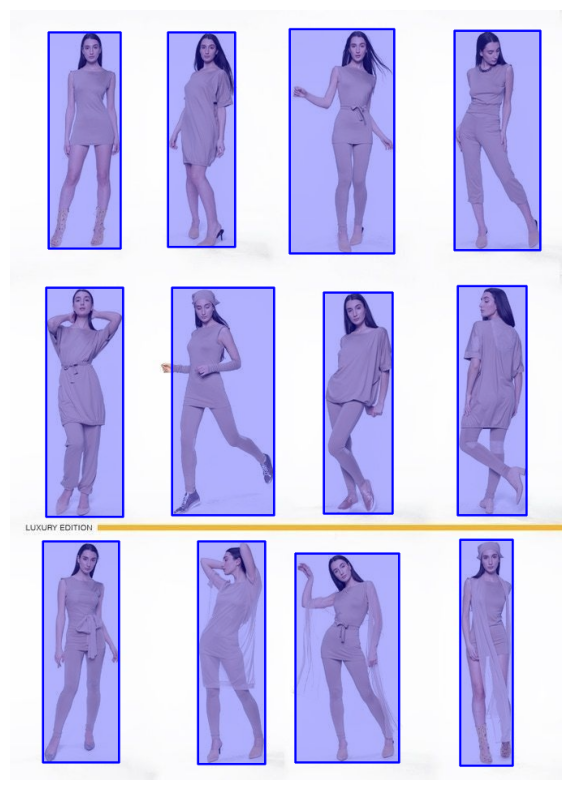

In [71]:
import matplotlib.pyplot as plt

orig_h, orig_w = img.shape[:2]

# Rescale back to original image size
scale_x = orig_w / 640.0
scale_y = orig_h / 480.0

scaled_boxes = []
for (x1, y1, x2, y2) in final_boxes:
    scaled_boxes.append([
        int(x1 * scale_x),
        int(y1 * scale_y),
        int(x2 * scale_x),
        int(y2 * scale_y)
    ])

overlay = img.copy()  # for filled boxes
for (x1, y1, x2, y2) in scaled_boxes:
    # filled rectangle on overlay
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), -1)
    # border on original
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

# alpha blend overlay with original
alpha = 0.3  # transparency factor
img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

# Convert BGR → RGB for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

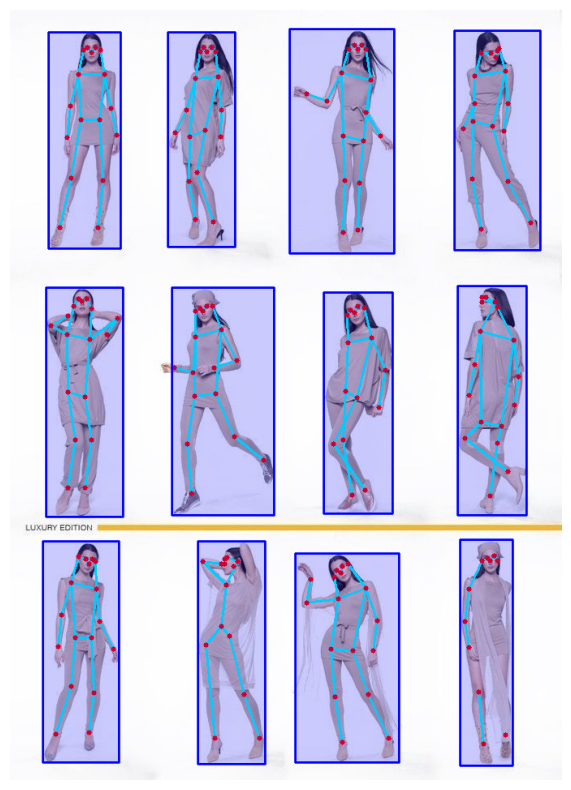

In [76]:
import cv2
import numpy as np
import torch
import torchvision
import onnxruntime
from matplotlib import pyplot as plt

session1 = onnxruntime.InferenceSession("mmpose/checkpoints/rtmpose_onnx_models/v9-m_mit.onnx", providers=["CPUExecutionProvider"])
input_name1 = session1.get_inputs()[0].name

def detect_persons(img_in, conf_threshold=0.3):
    # Make a copy of the image to avoid in-place issues
    img = img_in.copy()
    orig_h, orig_w = img.shape[:2]

    img_resized = cv2.resize(img, (640, 480))
    img_input = img_resized.astype(np.float32) / 255.0
    img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

    outputs = session1.run(None, {input_name1: img_input})

    output = outputs[0]  # shape (12, 6)
    iou_threshold = 0.4

    # Extract boxes and scores
    boxes = []
    scores = []
    for det in output:
        x1, y1, x2, y2, score, class_id = det  # xyxy format
        if score > conf_threshold and int(class_id) == 0:
            boxes.append([int(x1), int(y1), int(x2), int(y2)])
            scores.append(score)

    boxes = np.array(boxes)
    scores = np.array(scores)

    keep = nms(boxes, scores, iou_threshold)
    final_boxes = boxes[keep].astype(int).tolist()

    # Rescale back to original image size
    scale_x = orig_w / 640.0
    scale_y = orig_h / 480.0

    scaled_boxes = []
    for (x1, y1, x2, y2) in final_boxes:
        scaled_boxes.append([
            int(x1 * scale_x),
            int(y1 * scale_y),
            int(x2 * scale_x),
            int(y2 * scale_y)
        ])
    return scaled_boxes

# -------- Heatmap decode (HRNet ONNX) --------
def decode_single_person_heatmap(heatmaps, input_w, input_h, thr_kp=0.2):
    """
    heatmaps: (C, Hm, Wm)  -- 2D heatmap for each joint
    input_w, input_h: network input resolution (e.g., 288, 384)
    returns: (C, 3) [x, y, conf] in input image coordinates
    """
    C, Hm, Wm = heatmaps.shape
    kpts = np.zeros((C, 3), dtype=np.float32)

    for j in range(C):
        hm = heatmaps[j]
        # argmax
        y, x = np.unravel_index(hm.argmax(), hm.shape)
        conf = float(hm[y, x])

        # scale back to input image resolution
        x = x * (input_w / float(Wm))
        y = y * (input_h / float(Hm))

        if conf > thr_kp:
            kpts[j] = [x, y, conf]

    return kpts

# ----------------- top-down pose -----------------
def topdown_pose(img, session, input_name, in_w=288, in_h=384, thr_kp=0.2):
    boxes = detect_persons(img)
    poses_out = []

    for x1, y1, x2, y2 in boxes:

        crop = img[y1:y2, x1:x2].copy()
        if crop.size == 0:
            continue
        h_crop, w_crop = crop.shape[:2]
        crop_resized = cv2.resize(crop, (in_w, in_h))
        inp = crop_resized.astype(np.float32) / 255.0
        inp = inp.transpose(2,0,1)[np.newaxis, :]

        out = session.run(None, {input_name: inp})

        heatmaps = out[0].squeeze(0).astype(np.float32)  # (C, Hm, Wm)

        # decode to input coords
        kpts_in = decode_single_person_heatmap(heatmaps, in_w, in_h, thr_kp=thr_kp)

        kpts_full = np.zeros_like(kpts_in)
        for j in range(kpts_in.shape[0]):
            if kpts_in[j, 2] > 0:
                x_orig = kpts_in[j, 0] * (w_crop / in_w) + x1
                y_orig = kpts_in[j, 1] * (h_crop / in_h) + y1
                kpts_full[j] = [x_orig, y_orig, kpts_in[j, 2]]
        poses_out.append(kpts_full)

    return poses_out, boxes

# ----------------- visualization -----------------
def draw_poses(img, poses, boxes, skeleton=None, line_thickness=2, point_size=3):
    canvas = img.copy()
    if not poses: return canvas
    num_joints = poses[0].shape[0]

    if skeleton is None:
        skeleton = [
            [0,1],[0,2],[1,3],[2,4],[3,5],[4,6],
            [5,6],[5,7],[7,9],[6,8],[8,10],
            [5,11],[6,12],[11,12],[11,13],[13,15],[12,14],[14,16]
        ]
    skeleton = [pair for pair in skeleton if pair[0]<num_joints and pair[1]<num_joints]

    for kpts in poses:
        for a,b in skeleton:
            if kpts[a,2]>0 and kpts[b,2]>0:
                cv2.line(canvas,(int(kpts[a,0]),int(kpts[a,1])),
                                 (int(kpts[b,0]),int(kpts[b,1])),(255,255,0),line_thickness)
        for j in range(num_joints):
            if kpts[j,2]>0:
                cv2.circle(canvas,(int(kpts[j,0]),int(kpts[j,1])),point_size,(0,0,255),-1)

    overlay = img.copy()  # for filled boxes

    for x1, y1, x2, y2 in boxes:
        # filled rectangle on overlay
        cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), -1)
        # border on original
        cv2.rectangle(canvas, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # alpha blend overlay with original
    alpha = 0.2  # transparency factor
    canvas = cv2.addWeighted(overlay, alpha, canvas, 1 - alpha, 0)

    return canvas

# ----------------- run -----------------
img_path = "/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (4).jpg"
img = cv2.imread(img_path)
session = onnxruntime.InferenceSession(
    "mmpose/checkpoints/rtmpose_onnx_models/hrnet_coco_w48_384x288.onnx",
    providers=["CPUExecutionProvider"]
)
input_name = session.get_inputs()[0].name

poses, boxes = topdown_pose(img, session, input_name)
canvas = draw_poses(img, poses, boxes)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [78]:
pairs = [
    [0, 1], [0, 2],       # Nose to eyes
    [1, 3], [2, 4],       # Eyes to ears
    [3, 5], [4, 6],       # ears to shoulders
    [5, 6],               # Shoulders
    [5, 7], [7, 9],       # Left Arm
    [6, 8], [8, 10],      # Right Arm
    [5, 11], [6, 12],     # Torso
    [11, 12],             # Hip
    [11, 13], [13, 15],   # Left Leg
    [12, 14], [14, 16],   # Right Leg
]

upperskeleton = [
    [5, 7], [7, 9],       # Left Arm
    [6, 8], [8, 10],      # Right Arm
]

lowerskeleton = [
    [11, 13], [13, 15],   # Left Leg
    [12, 14], [14, 16],   # Right Leg
]

bodyskeleton = [
    [5, 6],               # Shoulders
    [5, 11], [6, 12],     # Torso
    [11, 12],
]

headskeleton = [
    [0, 1], [0, 2],       # Nose to eyes
    [1, 3], [2, 4],       # Eyes to ears
    [3, 5], [4, 6],       # ears to shoulders
]

# ----------------- visualization -----------------
def draw_poses(img, poses, boxes, line_thickness=2, point_size=3):
    canvas = img.copy()
    if not poses: return canvas
    num_joints = poses[0].shape[0]

    for kpts in poses:
        for a,b in upperskeleton:
            if kpts[a,2]>0 and kpts[b,2]>0:
                cv2.line(canvas,(int(kpts[a,0]),int(kpts[a,1])),
                                 (int(kpts[b,0]),int(kpts[b,1])),(255, 255, 0),line_thickness)
        for a,b in lowerskeleton:
            if kpts[a,2]>0 and kpts[b,2]>0:
                cv2.line(canvas,(int(kpts[a,0]),int(kpts[a,1])),
                                 (int(kpts[b,0]),int(kpts[b,1])),(255, 255, 0),line_thickness)
        for a,b in bodyskeleton:
            if kpts[a,2]>0 and kpts[b,2]>0:
                cv2.line(canvas,(int(kpts[a,0]),int(kpts[a,1])),
                                 (int(kpts[b,0]),int(kpts[b,1])),(0, 255, 255),line_thickness)
        for a,b in headskeleton:
            if kpts[a,2]>0 and kpts[b,2]>0:
                cv2.line(canvas,(int(kpts[a,0]),int(kpts[a,1])),
                                 (int(kpts[b,0]),int(kpts[b,1])),(0, 255, 0),line_thickness)
        for j in range(num_joints):
            if kpts[j,2]>0:
                cv2.circle(canvas,(int(kpts[j,0]),int(kpts[j,1])),point_size,(0, 0, 255),-1)

    overlay = img.copy()  # for filled boxes

    for x1, y1, x2, y2 in boxes:
        # filled rectangle on overlay
        cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), -1)
        # border on original
        cv2.rectangle(canvas, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # alpha blend overlay with original
    alpha = 0.2  # transparency factor
    canvas = cv2.addWeighted(overlay, alpha, canvas, 1 - alpha, 0)
    return canvas

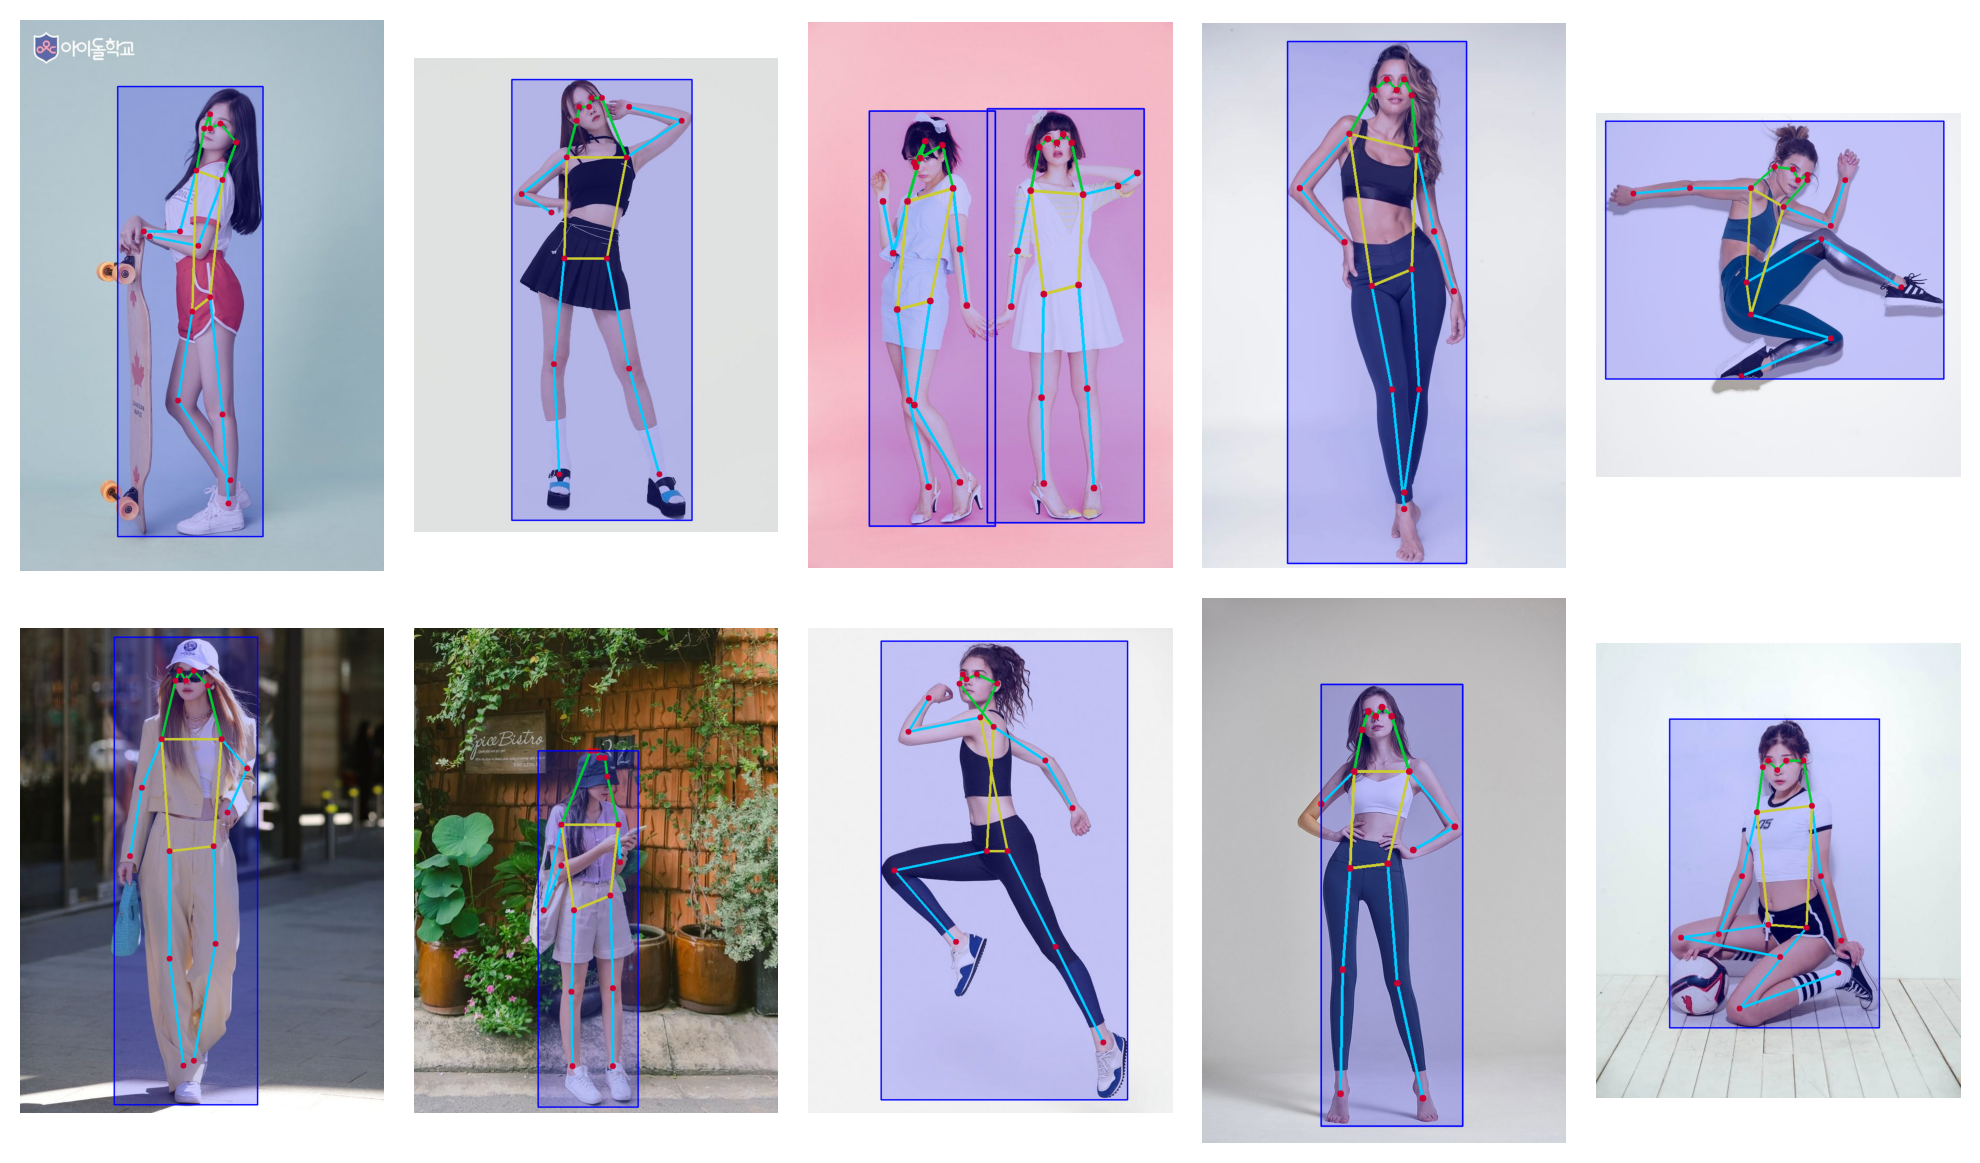

In [83]:
import os
import random
import cv2
import numpy as np
import torch
import torchvision
import onnxruntime
from matplotlib import pyplot as plt

# --- Config ---
val_dir = "mmpose/datasets/human-tests"

num_samples = 10

session = onnxruntime.InferenceSession(
        "mmpose/checkpoints/rtmpose_onnx_models/hrnet_coco_w48_384x288.onnx",
        providers=["CPUExecutionProvider"]
    )
input_name = session.get_inputs()[0].name

# --- Load Images ---
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

img_list = []

for img_name in selected_imgs:
    img_path = os.path.join(val_dir, img_name)
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_list.append((img_name, img_path, img_rgb))

# --- Plotting ---
cols = 5
rows = (len(img_list) + cols - 1) // cols
plt.figure(figsize=(10, 3 * rows), dpi=200)  # higher DPI = sharper

for idx, (img_name, img_path, img_rgb) in enumerate(img_list):
    img = cv2.imread(img_path)

    poses, boxes = topdown_pose(img, session, input_name, in_w=288, in_h=384)
    canvas = draw_poses(img, poses, boxes, line_thickness=4, point_size=6)
    canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(canvas)
    plt.axis('off')

plt.tight_layout()
plt.show()